# Welcome to the Photobooth Side View, Single Plant Tutorial, with an example! You can find this exact photobooth in the C basement. If you have multiple plants or separated leaves in the same image, use a different tutorial. This is for Release-4.0! 

Made by: Katie Murphy
Updated: May 16, 2023

First, import the necessary package. If you get an error here, make sure your kernel (upper right) is set to PlantCV, and that you have PlantCV installed. 

In [3]:
import cv2
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

Next, import a sample image. Your images need to be on the server. Remember, always keep your raw images separate from your newly processed images! You will need to change the path to your image, and also if you want specific output folders and directories. 

In [4]:
# Input/output options
args = WorkflowInputs(
    images=["./uploads/small-plant.jpeg"],
    names="image",
    result="example_results_oneimage_file.csv",
    outdir=".",
    writeimg=False,
    debug="plot"
    )

In [5]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

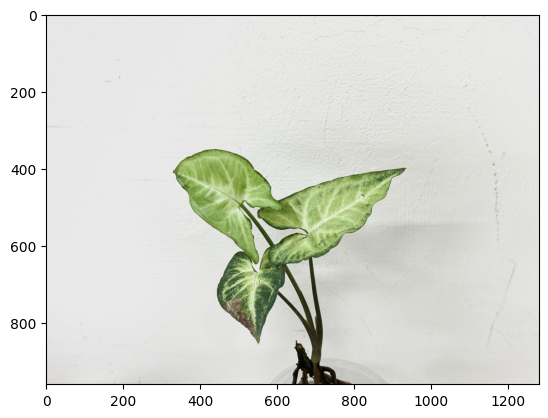

In [6]:
# Read in your image, which is based on the path you put above

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)




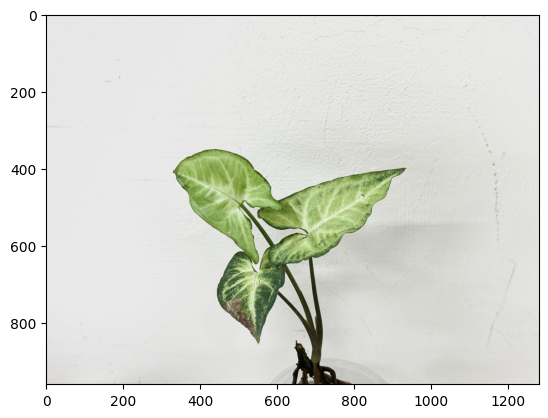

In [7]:
# Crop image if necessary. This is optional. 
crop_img = pcv.crop(img=img, x=1500, y=0, h=2900, w=2500)

In [9]:
# If your image is not straight, rotate it. Here our image is straight becasue our camera was on a flat surface, so we will rotate 0 degrees. 

rotate_img = pcv.transform.rotate(crop_img, 0, False)

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:2825: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'warpAffine'


In [32]:
#First, find the color card. You won't see any output of this function. 

dataframe1, start1, space1 = pcv.transform.find_color_card(rgb_img=rotate_img, background='light')

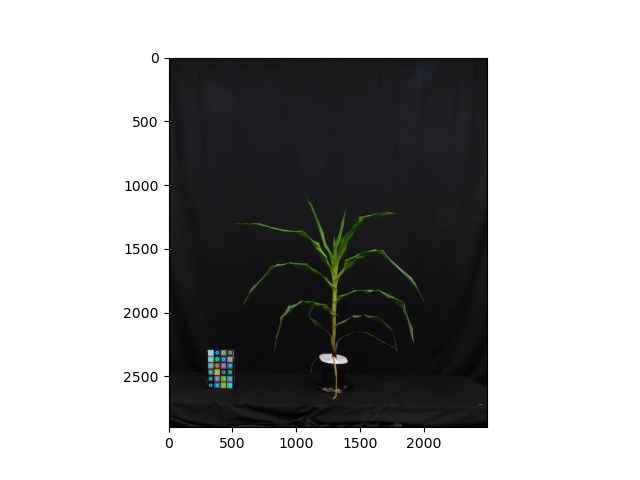

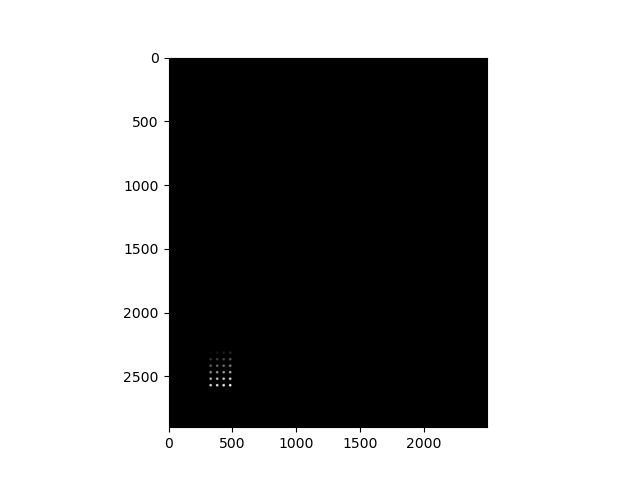

In [33]:
#Make a color card mask for your image. You should see that the color card has little circles on it, nicely inside the color squares.
#If the color card can't be found, you may need to set the start coordinate and spacing manually. 

card_mask = pcv.transform.create_color_card_mask(rotate_img, radius=10, start_coord=start1, 
                                                   spacing=space1, nrows=6, ncols=4)

In [34]:
#Make a color card matrix 

headers, card_matrix = pcv.transform.get_color_matrix(rgb_img=rotate_img, mask=card_mask)

In [35]:
# Define the standard color card matrix, we know what the colors of those chips should be in a "perfect" image, so we will correct to those values
# Look at where your white chip is in the image to determine which position your card is in (pos)


#pos     = reference value indicating orientation of the color card. The reference
       #         is based on the position of the white chip:
        #        pos = 0: bottom-left corner
        #        pos = 1: bottom-right corner
        #        pos = 2: top-right corner
        #        pos = 3: top-left corner

std_color_matrix = pcv.transform.std_color_matrix (pos=3)

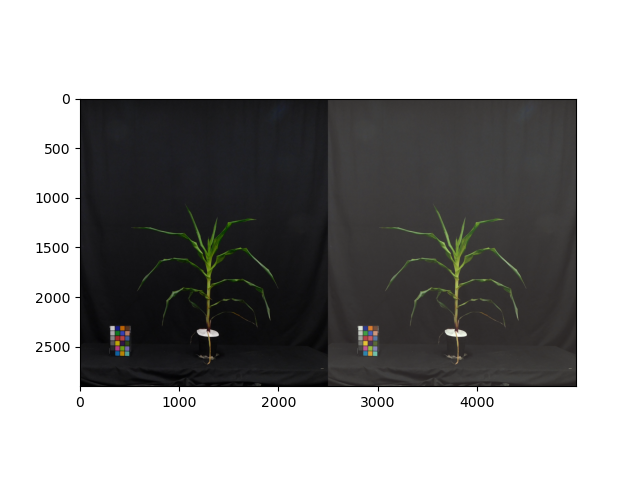

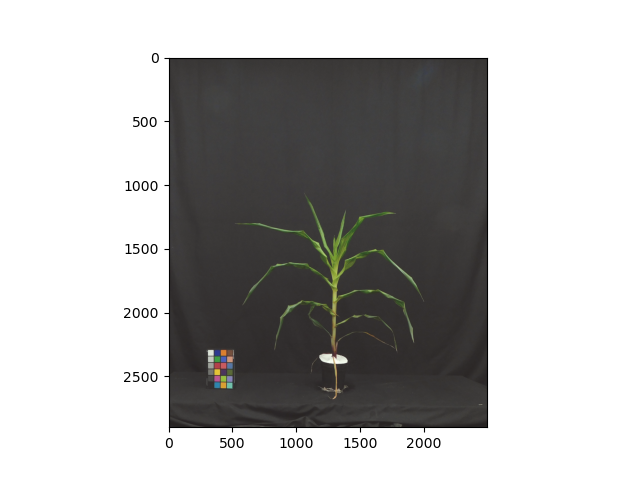

In [36]:
#Color correct your image to the standard values
#look at the image - does the color look good? If it looks crazy, you probably don't have the card found well and need to go back and define the start and spacing for the card

img_cc = pcv.transform.affine_color_correction(rotate_img, card_matrix, std_color_matrix)
pcv.plot_image(img_cc)

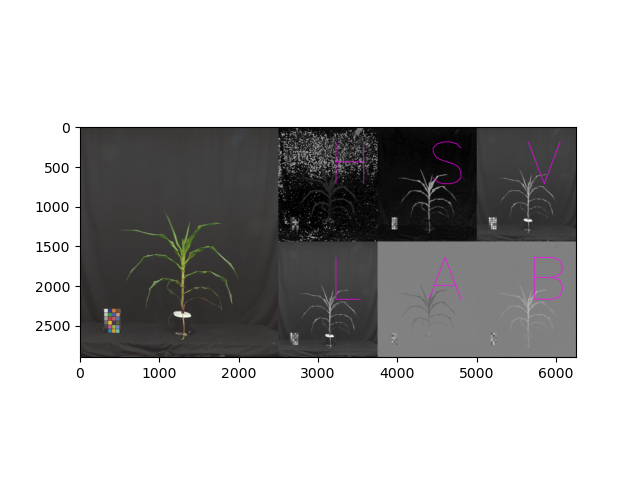

In [37]:
# Update params related to plotting so we can see better 
pcv.params.text_size=50
pcv.params.text_thickness=15


#Look at the colorspace - which of these looks the best for masking? Which channel makes the plant look most distinct?
colorspace_img = pcv.visualize.colorspaces(rgb_img=img_cc)

In [38]:
#If you want to save your color corrected image, do so here. Do NOT save over your raw image. 
#We are saving as a temporary image here becasue we want to use it for thresholding. 

pcv.print_image(img_cc, filename = "./color_corrected_img_temp.png")

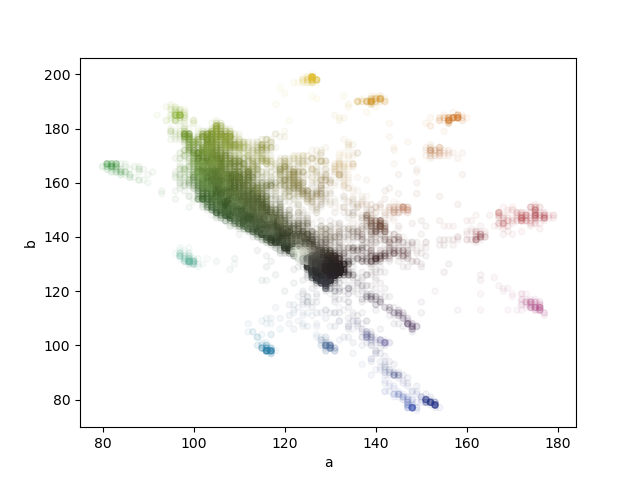

In [39]:
#Visualize all the colors to make decisions on how to threshold. I picked the two channels from the colorspace above that looked distinct

color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs = ["./color_corrected_img_temp.png"] , x_channel = "a", y_channel ="b" )



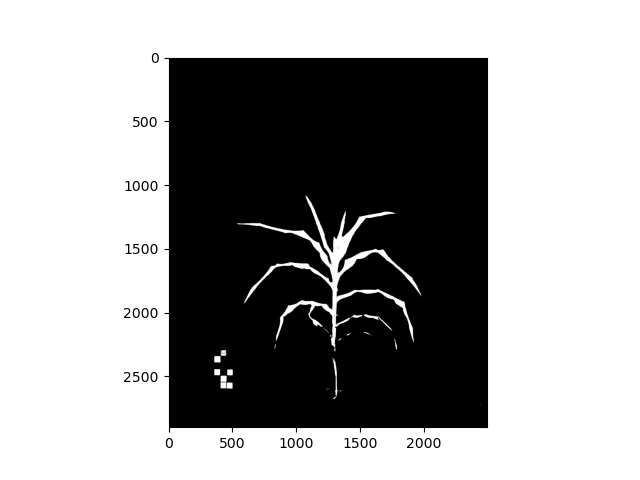

In [40]:
#Threshold your image by choosing points in the plot that will separate the green plant pixels from everything else. 
# It will draw a line between your two points and take every pixel "above" (if set to true). Do you get all of the plant?

thresh1 = pcv.threshold.dual_channels(rgb_img = img_cc, x_channel = "a", y_channel = "b", points = [(80,80),(125,140)], above=True)

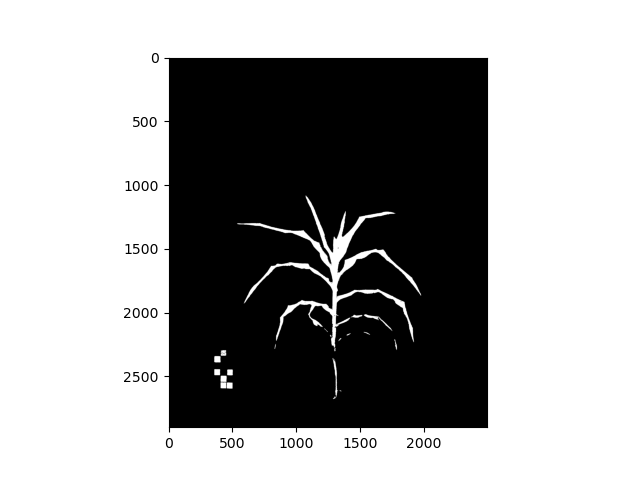

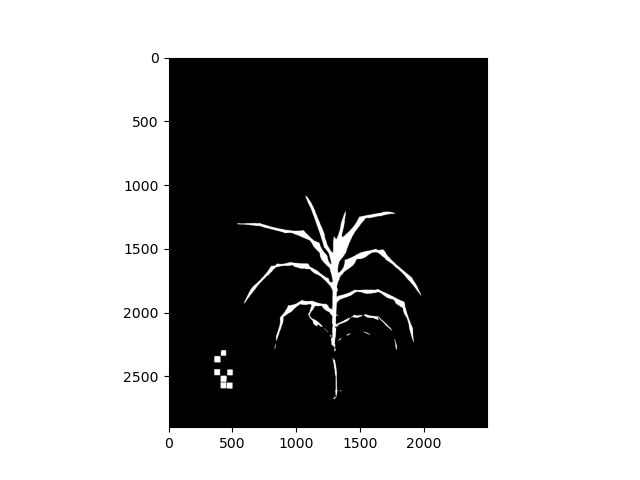

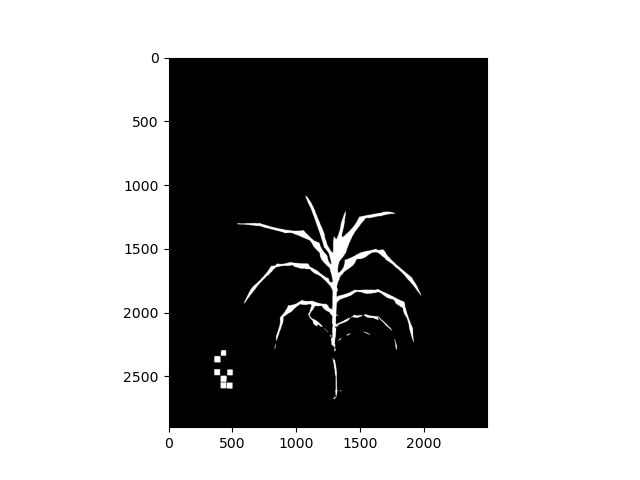

In [41]:
# Fill in small objects if the above threshold looks like there are "holes" in the leaves
a_fill_image = pcv.fill(bin_img=thresh1, size=50)
a_fill_image = pcv.fill_holes(a_fill_image)

pcv.plot_image(a_fill_image)

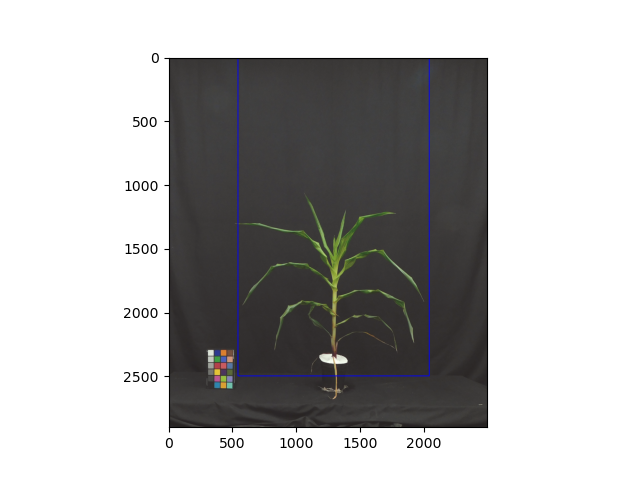

In [42]:
# Define the region of interest (ROI). This should include your plant, but not you color card or other things. 

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 

pcv.params.debug = "plot"

roi1 = pcv.roi.rectangle(img=img_cc, x=540, y=0, h=2500, w=1500)

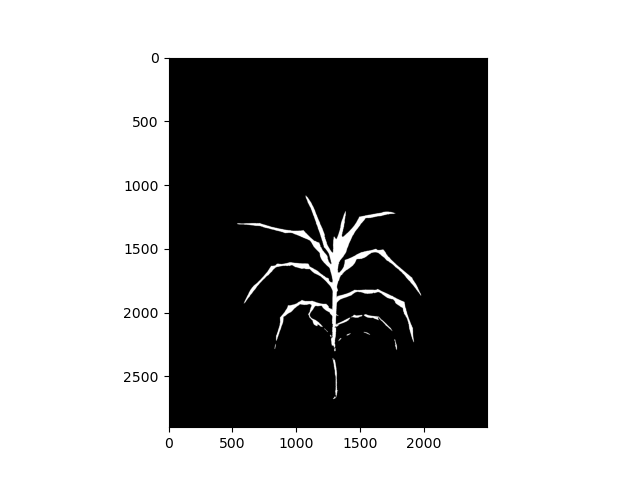

In [43]:
# Make a new filtered mask that only keeps the plant in your ROI and not objects outside of the ROI
# We have set to partial here so that if a leaf extends outside of your ROI it will still be selected. Switch to "cutto" if you have other plants that are getting selected on accident

# Inputs:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

kept_mask  = pcv.roi.filter(mask=a_fill_image, roi=roi1, roi_type='partial')


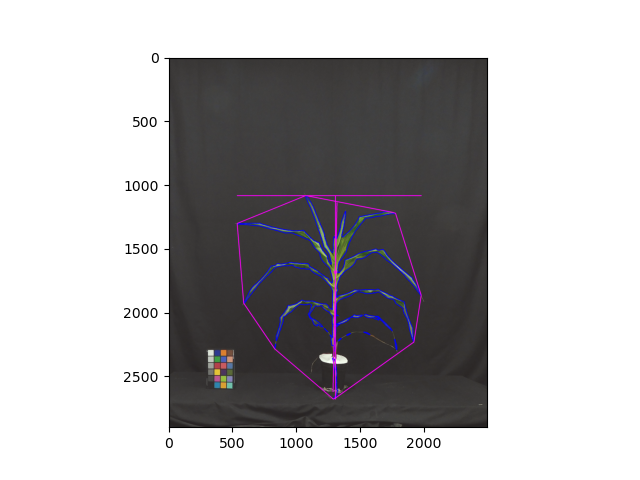

In [44]:
############### Analysis ################ 
  
# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 

analysis_image = pcv.analyze.size(img=img_cc, labeled_mask=kept_mask)


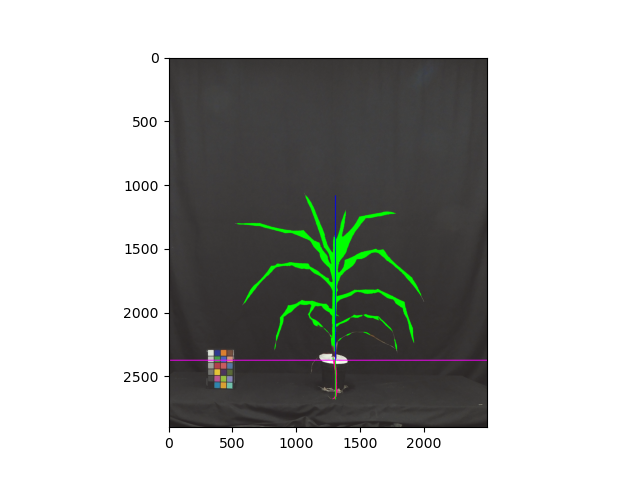

In [45]:
# Shape properties relative to user boundary line (optional). This is useful if your plant is hanging below the pot and you want height from the top of the pot.
# Set your line_position by finding the x-value at the top of the pot, hover your cursor to get that value

# Inputs:
#   img - RGB or grayscale image data 
#   obj - Single or grouped contour object 
#   mask - Binary mask of selected contours 
#   line_position - Position of boundary line (a value of 0 would draw a line 
#                   through the bottom of the image) 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

boundary_image = pcv.analyze.bound_horizontal(img=img_cc,labeled_mask=kept_mask, 
                                               line_position=2380, label="default")


In [46]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   colorspaces - 'all' (default), 'rgb', 'lab', or 'hsv'
#                 This is the data to be printed to the SVG histogram file  
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)

color_histogram = pcv.analyze.color(rgb_img=img_cc, labeled_mask=kept_mask, colorspaces='all', label="default")


alt.FacetChart(...)

In [47]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 

#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename=args.result)


## Congrats, you now know all the settings you like for this day of imaging! It's time to make this into a workflow so that it will analyze all your images at once and you can go have a cup of coffee. To do so, go back to the folder and open up the config_template.json file, and the config_workflow.py files, and you will edit them according to the values you changed in this file. 